# Gedwongen oscilaties en resonantie

### Importeren packages

In [1]:
import numpy as np
import scipy.stats as nst
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
import pandas as pd
import fit_routine as ft
sp.init_printing()

In [2]:
plt.style.use("plot_verslag")

## Voorbereidende opgaves

**Vraag 1: herschrijven uitdrukkingen**

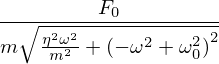

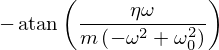

In [37]:
F0, m, omega0, omega, eta, k = sp.symbols("F0, m, omega0, omega, eta, k")
a_xw = F0/(m*sp.sqrt((omega0**2-omega**2)**2 + (omega*eta/m)**2))
var_a = [omega, omega0, m, eta, F0]
display(a_xw)
phi_w = -sp.atan((omega*eta/m)/(omega0**2-omega**2))
var_phi = [omega, omega0, m, eta]
display(phi_w)

In [38]:
print(sp.latex(phi_w))
print(sp.latex(a_xw))

- \operatorname{atan}{\left (\frac{\eta \omega}{m \left(- \omega^{2} + \omega_{0}^{2}\right)} \right )}
\frac{F_{0}}{m \sqrt{\frac{\eta^{2} \omega^{2}}{m^{2}} + \left(- \omega^{2} + \omega_{0}^{2}\right)^{2}}}


In [39]:
phi, A, X, w, b = sp.symbols('phi, A, X, w, b')
eqA = sp.Eq(a_xw, A)
eqphi = sp.Eq(phi_w, phi)
eq1 = sp.Eq(X, F0/k)
eq2 = sp.Eq(w, omega/omega0)
eq3 = sp.Eq(b, eta/sp.sqrt(2*k*m))
eq4 = sp.Eq(omega0, sp.sqrt(k/m))

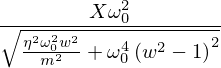

In [40]:
sols = sp.solve([eqA, eq1, eq2, eq3, eq4])
sols = sols[0]
sp.simplify(sols[A])

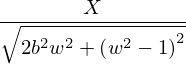

In [41]:
A_dim = X/sp.sqrt(2*w**2*b**2 + (w**2-1)**2)
display(A_dim)

In [42]:
min_w = sp.solve(sp.diff(A_dim, w), w)
min_w = min_w[2]
print(sp.latex(min_w))

\sqrt{- \left(b - 1\right) \left(b + 1\right)}


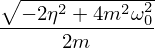

In [43]:
min_omega = sp.solve(sp.diff(a_xw, omega), omega)
min_omega = min_omega[2]
display(sp.simplify(min_omega))
num_fase = sp.lambdify([omega0, eta, m], min_omega, "numpy")

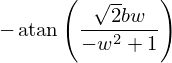

In [10]:
phi_dim = -sp.atan(sp.sqrt(2)*b*w/(1-w**2))
display(phi_dim)

In [11]:
print(sp.latex(A_dim))
print(sp.latex(phi_dim))

\frac{X}{\sqrt{2 b^{2} w^{2} + \left(w^{2} - 1\right)^{2}}}
- \operatorname{atan}{\left (\frac{\sqrt{2} b w}{- w^{2} + 1} \right )}


Er treedt amplitude-resonantie op wanneer $w=1$, dus als $\omega = \omega_0$

### plots dimensieloze functies

In [12]:
# maak numerieke functies van de dimensiloze functies
A_dim_num = sp.lambdify([X, w, b], A_dim, "numpy")
phi_dim_num = sp.lambdify([X, w, b], phi_dim, "numpy")
min_w_num = sp.lambdify(b, min_w, "numpy")

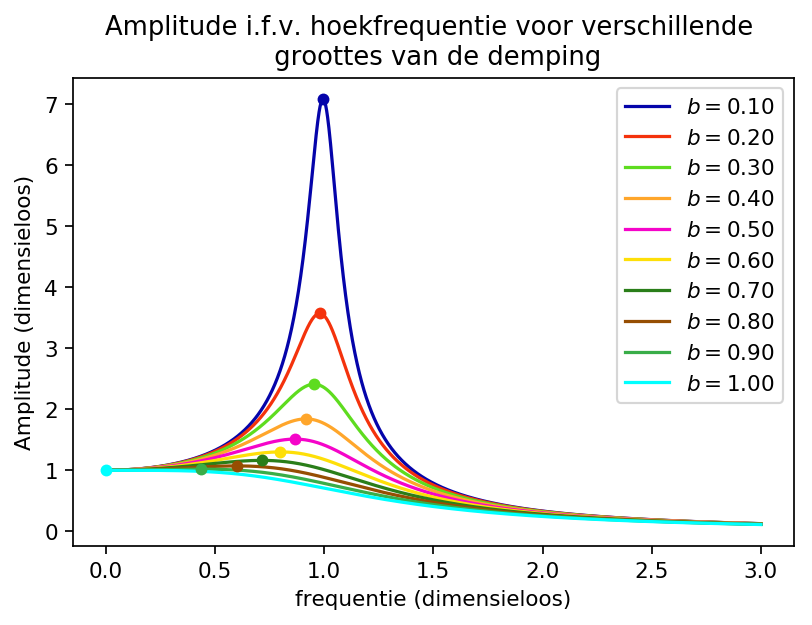

In [13]:
# definieer bereiken om te plotten
W = np.linspace(0, 3, 2000)
B = [(i+1)/10 for i in range(10)]
A_arr = [A_dim_num(1, W, demping) for demping in B]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(10):
    #ax = fig.add_subplot(5,2,i+1)
    ax.plot(W, A_arr[i], label="$b=%.2f$" %((i+1)/10))
    
next(ax._get_lines.prop_cycler)

for i in range(10):
    w = min_w_num(B[i])
    ax.plot(w, A_dim_num(1, w, B[i]), '.')
    
ax.set_xlabel("frequentie (dimensieloos)")
ax.set_ylabel("Amplitude (dimensieloos)")
plt.title("Amplitude i.f.v. hoekfrequentie voor verschillende \n groottes van de demping")
plt.legend()
    
plt.show()
fig.savefig("plots/dimensieloze_amplitude.pdf")

In [14]:
# functie die atan2 gebruikt voor berekenen inverse tangens
def phi_atan2(X, w, b):
    return -np.arctan2(-np.sqrt(2)*b*w, -1+w**2)

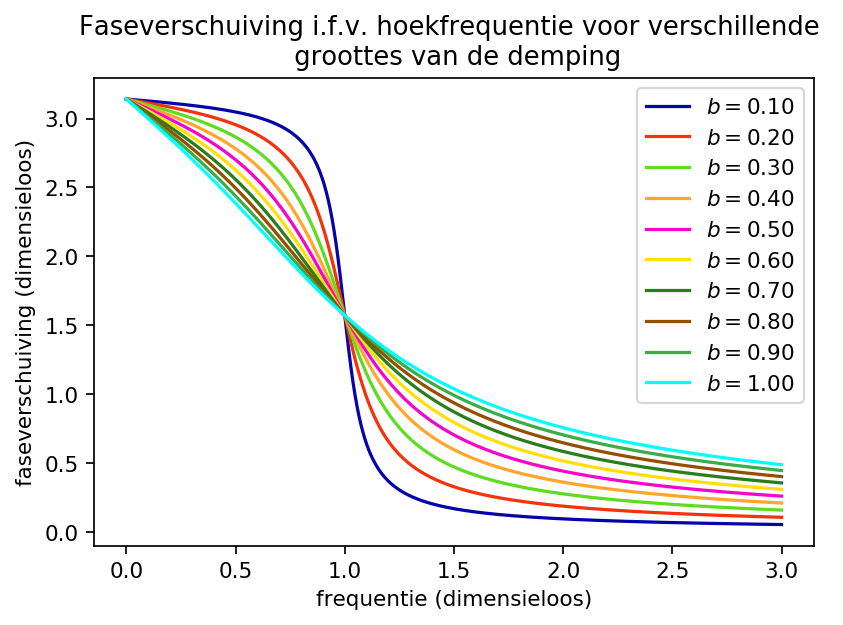

In [15]:
# definieer bereiken om te plotten
W = np.linspace(0, 3, 2000)
B = [(i+1)/10 for i in range(10)]
A_arr = [phi_atan2(1, W, demping) for demping in B]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for i in range(10):
    #ax = fig.add_subplot(5,2,i+1)
    ax.plot(W, A_arr[i], label="$b=%.2f$" %((i+1)/10))
    
ax.set_xlabel("frequentie (dimensieloos)")
ax.set_ylabel("faseverschuiving (dimensieloos)")
plt.title("Faseverschuiving i.f.v. hoekfrequentie voor verschillende \n groottes van de demping")
plt.legend()
    
plt.show()

fig.savefig("plots/dimensieloze_faseverschuiving.pdf")

## Data practicum

In [16]:
df_small_res = pd.read_excel("Data_gedwongen_oscillator.xlsx")
df_big_res = pd.read_excel("Data_gedwongen_oscillatie_schijf.xlsx")
df_small_res['SD Amp'] *= np.sqrt(10)
df_small_res['SD fase'] *= 2
df_big_res['SD Amp [mm]'] *= np.sqrt(10)
df_big_res['SD Fase [°]'] *= 2
dsys_A = 0.002
dsys_fase = 5*np.pi/180

df_small_res = df_small_res.round(4)
table_small_res = df_small_res.to_latex()
print(table_small_res)

df_big_res = df_big_res.round(4)
table_big_res = df_big_res.to_latex()
print(table_big_res)

### De te fitten functies en methodes om te fitten

In [17]:
f_temp = sp.lambdify(var_a, a_xw, "numpy")
def f_A(omega, omega0, eta_m, F0_m):
    return f_temp(omega, omega0, 1, eta_m, F0_m)
def f_phi(omega, omega0, eta):
    return np.arctan2(eta*omega, -(omega**2-omega0**2))

In [18]:
# de volgorde van de parameters
display(var_a, var_phi)

In [19]:
sym_var_a = [r"\omega_0", r"\eta/m", r"F_0/m"]
sym_var_phi = [r"\omega_0", r"\eta/m", r"d/m"]

### Fits kleine weerstand

transformeer de data naar numpy arrays

In [20]:
df_small_res.columns

Index(['frequentie [Hz]', 'SD freq', 'Amplitude [mm]', 'SD Amp', 'fase[°]',
       'SD fase'],
      dtype='object')

In [21]:
df = df_small_res
f = df['frequentie [Hz]']
omega = 2*np.pi*f
domega = 2*np.pi*df["SD freq"]
domega = np.maximum(domega, 2*np.pi*0.01*np.ones_like(domega))
# Amplitude en fouten hierop, verander de eenheid naar meter
A = df['Amplitude [mm]']
A *= 0.001
# voeg ook de systematische fout toe aan de fout op de amplitude
dA = df['SD Amp']
dA *= 0.001
dA = np.maximum(dA, dsys_A*np.ones_like(dA))
# de faseverschuiving en de fout hierop, verander naar radialen
fase = df['fase[°]']
fase *= np.pi/180
dfase = df['SD fase']
dfase *= np.pi/180
dfase = np.maximum(dfase, dsys_fase*np.ones_like(dfase))

In [22]:
fit = ft.fit(f_A, omega, A, dA, (11, 1, 1), (0.01, 0.01, 0.01))

In [23]:
for i in range(len(fit['param'])):
    display("%s: %f +- %f" %(str(var_a[i+1]), fit['param'][i], fit['stdv'][i][0][0]))

'omega0: 11.342246 +- -0.009908'

'm: 0.680025 +- -0.010950'

'eta: 0.708690 +- -0.007835'

In [24]:
def dphi(x, a, c, d):
    return f_phi(x, a, c) + d
#fit_fase = ft.fit(f_phi, omega, fase, dfase, (11, 8, 3.7), (0.01, 0.01, 0.01))
fit_fase2 = ft.fit(dphi, omega, fase, dfase, (11, 2, -0.4), (0.01, 0.01, 0.01))

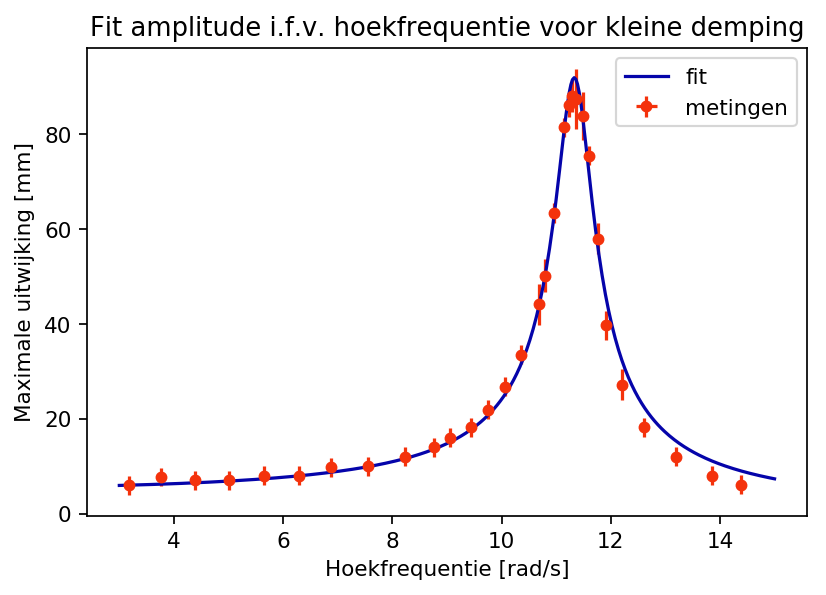

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

X = np.linspace(3, 15, 400)
Y = np.array([f_A(x, *fit['param']) for x in X])
ax.plot(X, Y*1000, label="fit")
#X = np.linspace(0.4, 15, 400)
#Y = [f_A(x, *fit_fase['param'], fit['param'][-1]) for x in X]
#ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [f_A(x, *fit_fase2['param'][:-1], fit['param'][-1]) for x in X]
#ax.plot(X, Y)
ax.errorbar(omega, A*1000, dA*1000, domega, fmt='.', label="metingen")

ax.set_xlabel("Hoekfrequentie [rad/s]")
ax.set_ylabel("Maximale uitwijking [mm]")
plt.title("Fit amplitude i.f.v. hoekfrequentie voor kleine demping")
plt.legend()

plt.show()

fig.savefig("plots/fit_amplitude_klein.pdf")

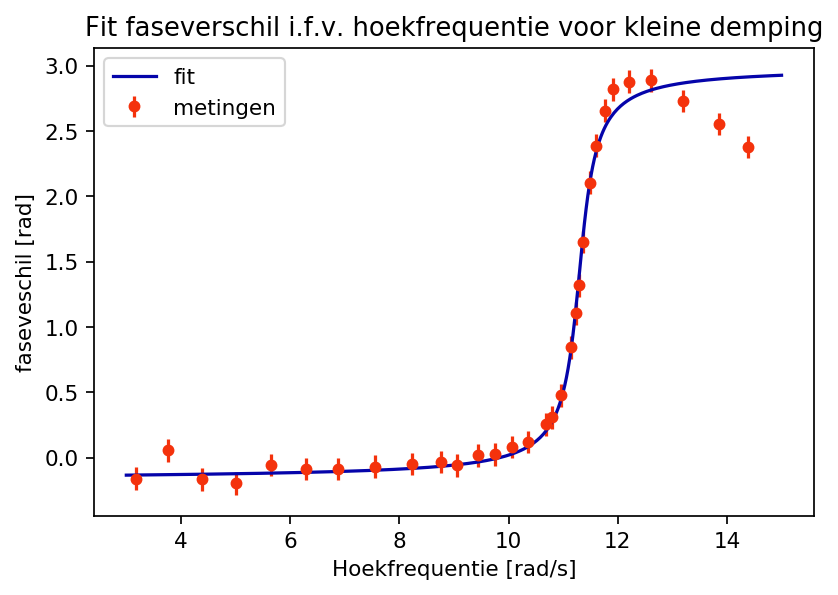

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)


#X = np.linspace(0.4, 15, 400)
#Y = [f_phi(x, *fit_fase['param']) for x in X]
#ax.plot(X, Y)
#X = np.linspace(0.4, 15, 400)
#Y = [f_phi(x, *fit['param'][:-1]) for x in X]
#ax.plot(X, Y)
X = np.linspace(3, 15, 400)
Y = [dphi(x, *fit_fase2['param']) for x in X]
ax.plot(X, Y, label="fit")
ax.errorbar(omega, fase, dfase, fmt='.', label="metingen")

ax.set_xlabel("Hoekfrequentie [rad/s]")
ax.set_ylabel("faseveschil [rad]")
plt.title("Fit faseverschil i.f.v. hoekfrequentie voor kleine demping")
plt.legend()

plt.show()

fig.savefig("plots/fit_fase_klein.pdf")

In [27]:
fit

{'param': array([11.34224571,  0.68002541,  0.70869028]),
 'stdv': [(array([-0.00990796]), array([0.00981421])),
  (array([-0.01095035]), array([0.01120849])),
  (array([-0.00783454]), array([0.00783454]))],
 'p': 0.41696105290353347,
 'chi2': 28.9127960839234}

In [28]:
for i in range(3):
    print(r"$ %.3f \pm %.3f $ & " %(fit['param'][i], fit['stdv'][i][0][0]))

$ 11.342 \pm -0.010 $ & 
$ 0.680 \pm -0.011 $ & 
$ 0.709 \pm -0.008 $ & 


In [29]:
for param in sym_var_a:
    print(r"$ %s $ & " %param)

$ \omega_0 $ & 
$ \eta/m $ & 
$ F_0/m $ & 


In [30]:
fit_fase2

{'param': array([11.30077435,  0.46085853, -0.14447298]),
 'stdv': [(array([-0.01016325]), array([0.01017033])),
  (array([-0.02935235]), array([0.03081431])),
  (array([0.01567353]), array([-0.01567351]))],
 'p': 3.3757822257562964e-06,
 'chi2': 75.20879782252706}

In [31]:
for i in range(3):
    print(r"& $%.3f \pm %.3f$" %(fit_fase2['param'][i], fit_fase2['stdv'][i][1][0]))

& $11.301 \pm 0.010$
& $0.461 \pm 0.031$
& $-0.144 \pm -0.016$


Vergelijk de waardes voor de parameters bekomen uit de fit van de amplitude en de fit van de fase

In [32]:
# vergelijk de omega_0
x = fit['param'][0] - fit_fase2['param'][0]
s2 = fit['stdv'][0][1][0]**2 + fit['stdv'][0][1][0]**2
test_waarde = x/np.sqrt(s2)
p_waarde = 1-nst.norm.cdf(test_waarde)
display(test_waarde, p_waarde)

In [33]:
# vergelijk de eta/m
x = fit['param'][1] - fit_fase2['param'][1]
s2 = fit['stdv'][1][1][0]**2 + fit['stdv'][1][1][0]**2
test_waarde = x/np.sqrt(s2)
p_waarde = 1-nst.norm.cdf(test_waarde)
display(test_waarde, p_waarde)

In [34]:
# sla de waardes en stdvs van eta/m op om te vergelijken met die van het experiment met een grote coëfficiënt
eta_A_klein = fit['param'][1]
S_eta_A_klein = fit['stdv'][1][1][0]
eta_phi_klein = fit_fase2['param'][1]
S_eta_phi_klein = fit_fase2['stdv'][1][1][0]

In [44]:
num_fase(fit['param'][0], fit['param'][1], 1)

### Fits grote weerstand

transformeer de data naar numpy arrays

In [45]:
df = df_big_res
f = df['Frequentie [Hz]'].values
omega = 2*np.pi*f
# Amplitude en fouten hierop, verander de eenheid naar meter
A = df['Amplitude [mm]'].values
A *= 0.001
# voeg ook de systematische fout toe aan de fout op de amplitude
dA = df['SD Amp [mm]'].values
dA *= 0.001
dA = np.maximum(dA, 2*dsys_A*np.ones_like(dA)/np.sqrt(12))
# de faseverschuiving en de fout hierop, verander naar radialen
fase = df['Fase [°]']
fase *= np.pi/180
dfase = df['SD Fase [°]']
dfase *= np.pi/180
dfase = np.maximum(dfase, 2*dsys_fase*np.ones_like(dfase)/np.sqrt(12))

In [46]:
fit = ft.fit(f_A, omega, A, dA, (10, 1, 1), ( 0.01, 0.01, 0.01))

In [47]:
fit_fase2 = ft.fit(dphi, omega, fase, dfase, (11, 0.5, -0.4), (0.01, 0.01, 0.01))

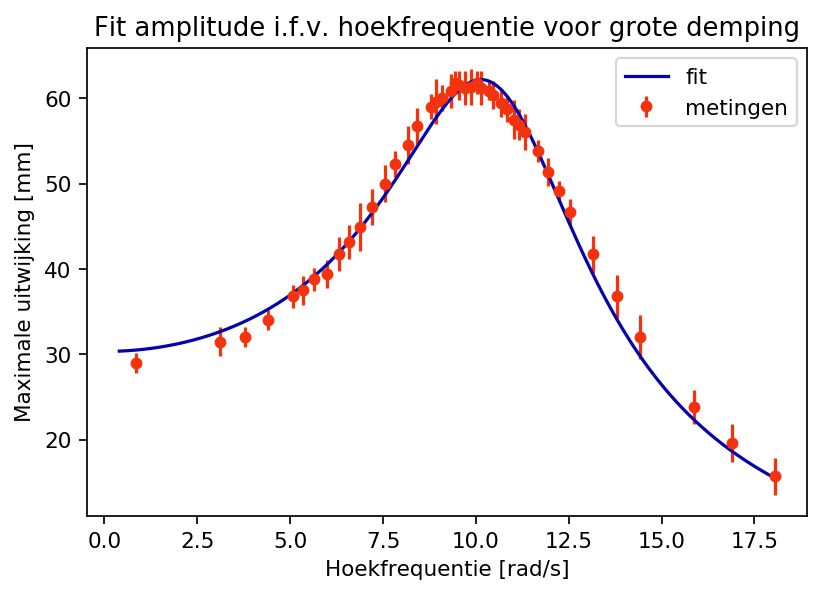

In [48]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

X = np.linspace(0.4, 18, 400)
Y = np.array([f_A(x, *fit['param']) for x in X])
ax.plot(X, 1000*Y, label="fit")
#X = np.linspace(0.4, 18, 400)
#Y = [f_A(x, *fit_fase['param'], fit['param'][-1]) for x in X]
#ax.plot(X, Y)
#X = np.linspace(0.4, 18, 400)
#Y = [f_A(x, *fit_fase2['param'][:-1], fit['param'][-1]) for x in X]
#ax.plot(X, Y)
ax.errorbar(omega, A*1000, dA*1000, fmt='.', label="metingen")

ax.set_xlabel("Hoekfrequentie [rad/s]")
ax.set_ylabel("Maximale uitwijking [mm]")
plt.title("Fit amplitude i.f.v. hoekfrequentie voor grote demping")
plt.legend()

plt.show()
fig.savefig("plots/fit_amplitude_groot.pdf")

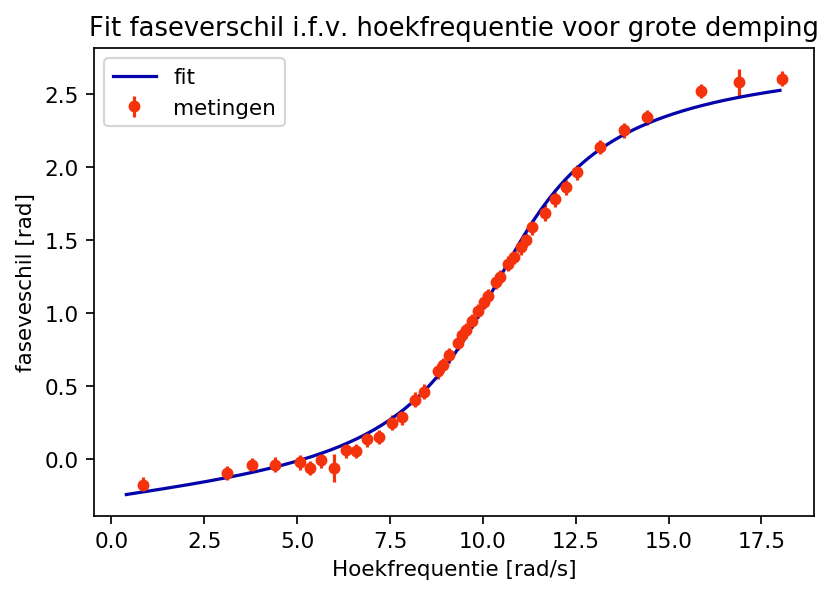

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

#X = np.linspace(0.4, 18, 400)
#Y = [f_phi(x, *fit_fase['param']) for x in X]
#ax.plot(X, Y)
#X = np.linspace(0.4, 18, 400)
#Y = [f_phi(x, *fit['param'][:-1]) for x in X]
#ax.plot(X, Y)
X = np.linspace(0.4, 18, 400)
Y = [dphi(x, *fit_fase2['param']) for x in X]
ax.plot(X, Y, label="fit")
ax.errorbar(omega, fase, dfase, fmt='.', label="metingen")

ax.set_xlabel("Hoekfrequentie [rad/s]")
ax.set_ylabel("faseveschil [rad]")
plt.title("Fit faseverschil i.f.v. hoekfrequentie voor grote demping")
plt.legend()

plt.show()

fig.savefig("plots/fit_fase_groot.pdf")

In [50]:
fit

{'param': array([10.85138254,  5.47149544,  3.57257037]),
 'stdv': [(array([-0.03217257]), array([0.03220401])),
  (array([-0.03663994]), array([0.03704528])),
  (array([-0.01815199]), array([0.01815199]))],
 'p': 0.9508133735699713,
 'chi2': 26.45555406591369}

In [51]:
for i in range(3):
    print(r"$ %.3f \pm %.3f $ & " %(fit['param'][i], fit['stdv'][i][0][0]))

$ 10.851 \pm -0.032 $ & 
$ 5.471 \pm -0.037 $ & 
$ 3.573 \pm -0.018 $ & 


In [52]:
for param in sym_var_a:
    print(r"$ %s $ & " %param)

$ \omega_0 $ & 
$ \eta/m $ & 
$ F_0/m $ & 


In [53]:
fit_fase2

{'param': array([10.60839254,  4.38072891, -0.25814371]),
 'stdv': [(array([-0.02718103]), array([0.02722027])),
  (array([-0.09223361]), array([0.09417633])),
  (array([0.0078473]), array([-0.00784728]))],
 'p': 0.6406412067028691,
 'chi2': 36.231040649360885}

In [54]:
for i in range(3):
    print(r"& $%.3f \pm %.3f$" %(fit_fase2['param'][i], fit_fase2['stdv'][i][1][0]))

& $10.608 \pm 0.027$
& $4.381 \pm 0.094$
& $-0.258 \pm -0.008$


In [55]:
# vergelijk de omega_0
x = fit['param'][0] - fit_fase2['param'][0]
s2 = fit['stdv'][0][1][0]**2 + fit['stdv'][0][1][0]**2
test_waarde = x/np.sqrt(s2)
p_waarde = 1-nst.norm.cdf(test_waarde)
display(test_waarde, p_waarde)

In [56]:
# vergelijk de eta/m
x = fit['param'][1] - fit_fase2['param'][1]
s2 = fit['stdv'][1][1][0]**2 + fit['stdv'][1][1][0]**2
test_waarde = x/np.sqrt(s2)
p_waarde = 1-nst.norm.cdf(test_waarde)
display(test_waarde, p_waarde)

In [57]:
# sla de waardes en stdvs van eta/m op om te vergelijken met die van het experiment met een grote coëfficiënt
eta_A_groot = fit['param'][1]
S_eta_A_groot = fit['stdv'][1][1][0]
eta_phi_groot = fit_fase2['param'][1]
S_eta_phi_groot = fit_fase2['stdv'][1][1][0]

In [58]:
# bereken de p-waarde voor de nulhypothese eta_groot <= eta_klein
x_A = eta_A_groot - eta_A_klein
s_A = S_eta_A_groot**2 + S_eta_A_klein**2
val_A = x_A/np.sqrt(s_A)
p_A = 1-nst.norm.cdf(val_A)
print("testwaarde voor de hypothesetest eta_groot <= eta_klein, parameter uit de fit van de amplitude: %.2f, p-waarde: %.5f" %(val_A, p_A))
x_phi = eta_phi_groot - eta_phi_klein
s_phi = S_eta_phi_groot**2 + S_eta_phi_klein**2
val_phi = x_phi/np.sqrt(s_phi)
p_phi = 1-nst.norm.cdf(val_phi)
print("testwaarde voor de hypothesetest eta_groot <= eta_klein, parameter uit de fit van de fase: %.2f, p-waarde: %.5f" %(val_phi, p_phi))

testwaarde voor de hypothesetest eta_groot <= eta_klein, parameter uit de fit van de amplitude: 123.80, p-waarde: 0.00000
testwaarde voor de hypothesetest eta_groot <= eta_klein, parameter uit de fit van de fase: 39.56, p-waarde: 0.00000


In [59]:
num_fase(fit['param'][0], fit['param'][1], 1)

In [65]:
a = 11.3
sa = 0.3
b = 10.1
sb = 0.3
z = (a-b)/np.sqrt(sa**2 + sb**2)
z

In [66]:
1-nst.norm.cdf(z)